<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/Smiles_generation_LanguageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pubchempy transformers datasets rdkit pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and

In [1]:
"""
Enhanced SMILES Generator using Chemistry-Aware Language Models
"""
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import pubchempy as pcp
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
import warnings
warnings.filterwarnings('ignore')

# Disable WANDB
os.environ["WANDB_DISABLED"] = "true"

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SMILESDataset(Dataset):
    """Custom dataset for SMILES strings"""
    def __init__(self, smiles_list, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.inputs = []

        for smiles in tqdm(smiles_list, desc="Tokenizing SMILES"):
            # Add special tokens for better learning
            text = f"<smiles>{smiles}</smiles>"
            encodings = tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            self.inputs.append({
                'input_ids': encodings['input_ids'][0],
                'attention_mask': encodings['attention_mask'][0]
            })

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

def download_chembl_smiles(max_compounds=500):

    # Get the first 5000 compounds from PubChem
    compounds = pcp.get_compounds(range(1, max_compounds), namespace='cid')

    with open("smiles.txt", "w") as f:
      for compound in compounds:
        if compound.isomeric_smiles:
            f.write(compound.isomeric_smiles + "\n")

    # Load SMILES strings from smiles.txt into a list
    with open("smiles.txt", "r") as f: sample_smiles = [line.strip() for line in f if line.strip()]
    print(sample_smiles[:5])

    # Validate and filter SMILES
    valid_smiles = []
    for smi in sample_smiles:
        mol = Chem.MolFromSmiles(smi)
        if mol: valid_smiles.append(smi)

    return valid_smiles[:]

def preprocess_dataset():
    """Preprocess SMILES strings and prepare datasets"""
    # Get SMILES data
    smiles_list = download_chembl_smiles(max_compounds=500)
    print(f"Total valid SMILES: {len(smiles_list)}")

    # Split into train/validation sets
    np.random.shuffle(smiles_list)
    split_idx = int(len(smiles_list) * 0.9)
    train_smiles = smiles_list[:split_idx]
    val_smiles = smiles_list[split_idx:]

    return train_smiles, val_smiles

def create_tokenizer_and_model(model_name="gpt2-medium"):
    """Initialize tokenizer and model"""
    # Use a chemistry-aware model if available
    # For demo, we'll fine-tune GPT-2-medium which has better capacity than base GPT-2
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add special tokens for SMILES
    special_tokens = {
        'pad_token': '[PAD]',
        'bos_token': '<smiles>',
        'eos_token': '</smiles>',
        'additional_special_tokens': ['[C]', '[O]', '[N]', '[S]', '[Cl]', '[F]', '[Br]', '[I]']
    }

    # Add special tokens to tokenizer
    tokenizer.add_special_tokens(special_tokens)

    # Initialize model
    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.resize_token_embeddings(len(tokenizer))

    return tokenizer, model

def train_smiles_generator(model, tokenizer, train_smiles, val_smiles, output_dir="./smiles-generator"):
    """Train the SMILES generator model"""
    # Create datasets
    train_dataset = SMILESDataset(train_smiles, tokenizer)
    val_dataset = SMILESDataset(val_smiles, tokenizer)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Configure training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=2,  # Adjust based on dataset size
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        save_steps=5000,
        prediction_loss_only=False,
        logging_dir=f"{output_dir}/logs",
        logging_steps=5000,
        save_total_limit=1,
        fp16=True if torch.cuda.is_available() else False,
        gradient_accumulation_steps=2,
        learning_rate=1e-4,  # Lower learning rate for fine-tuning
    )

    # Data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # We're doing causal language modeling, not masked
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    # Train the model
    print("Starting training...")
    trainer.train()

    # Save model and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model saved to {output_dir}")

    return model, tokenizer

def generate_novel_smiles(model, tokenizer, num_sequences=25, max_length=100, temperature=0.7, top_p=0.9):
    """Generate novel SMILES strings"""
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Generation parameters
    generation_config = {
        "do_sample": True,
        "top_p": top_p,
        "temperature": temperature,
        "top_k": 50,
        "max_length": max_length,
        "num_return_sequences": num_sequences,
        "pad_token_id": tokenizer.pad_token_id,
        "bos_token_id": tokenizer.bos_token_id,
        "eos_token_id": tokenizer.eos_token_id,
    }

    # Generate sequences
    input_ids = tokenizer("<smiles>", return_tensors="pt").input_ids.to(device)

    # Generate with guidance
    outputs = model.generate(input_ids, **generation_config)

    # Decode generated SMILES
    generated_smiles = []
    for output in outputs:
        decoded = tokenizer.decode(output, skip_special_tokens=True)
        # Extract SMILES string between tags if present
        if "<smiles>" in decoded and "</smiles>" in decoded:
            smiles = decoded.split("<smiles>")[1].split("</smiles>")[0].strip()
        else:
            smiles = decoded.strip()
        generated_smiles.append(smiles)

    return generated_smiles

def validate_smiles(smiles_list):
    """Validate generated SMILES and calculate properties"""
    valid_mols = []
    valid_smiles = []
    properties = []

    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                valid_mols.append(mol)
                valid_smiles.append(smiles)

                # Calculate basic molecular properties
                properties.append({
                    'SMILES': smiles,
                    'MolWeight': round(Descriptors.MolWt(mol), 2),
                    'LogP': round(Descriptors.MolLogP(mol), 2),
                    'NumHDonors': Descriptors.NumHDonors(mol),
                    'NumHAcceptors': Descriptors.NumHAcceptors(mol),
                    'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
                    'TPSA': round(Descriptors.TPSA(mol), 2)
                })
        except:
            continue

    print(f"Generated {len(smiles_list)} SMILES, {len(valid_smiles)} valid ({len(valid_smiles)/len(smiles_list)*100:.1f}%)")

    return valid_mols, valid_smiles, properties

def visualize_molecules(mols, n_per_row=5, max_mols=10):
    """Visualize generated molecules"""
    if len(mols) > max_mols:
        mols = mols[:max_mols]

    img = Draw.MolsToGridImage(
        mols,
        molsPerRow=n_per_row,
        subImgSize=(250, 250),
        legends=[f"Mol {i+1}" for i in range(len(mols))]
    )
    return img




Using device: cpu


In [2]:
train_smiles, val_smiles = preprocess_dataset()

['CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C', 'CC(=O)OC(CC(=O)O)C[N+](C)(C)C', 'C1=CC(C(C(=C1)C(=O)O)O)O', 'CC(CN)O', 'C(C(=O)COP(=O)(O)O)N']
Total valid SMILES: 499


In [3]:
# Initialize tokenizer and model
tokenizer, model = create_tokenizer_and_model()

# Train model
model, tokenizer = train_smiles_generator(model, tokenizer, train_smiles, val_smiles)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Tokenizing SMILES: 100%|██████████| 50/50 [00:00<00:00, 4597.91it/s]
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Train dataset size: 449
Validation dataset size: 50
Starting training...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Model saved to ./smiles-generator


In [19]:
# Generate novel molecules
generated_smiles = generate_novel_smiles(model, tokenizer, num_sequences=100)

In [20]:
generated_smiles

['C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O',
 'C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O',
 'C(C(C1)C(=O)O)O)O',
 'CC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)OP(=O)O)O)OP(=O)O)O)(O)O)O)(O)(O)OP(=O)O)O)O)(O)O)(O)O)O)O)',
 'CC(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O)O)O',
 'C1C1C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O',
 'C1=C(C(C(C(C(C(=C(C(C(C(O)O)O)O)O)O)O',
 'C1C1=O)N',
 'C1=CCCC=C(=CC1C1C(=C(C1)O)C(C(C(=O)O)N)N)O)C(=O)O)O)C(=O)O)O)C(=O',
 'CC(C(=O)O)O)N)N)O',
 'C(C(C(C(C(C(=O)O)O)O)O)O)O)O)O)O)O)O',
 'C1=C(=C(=O)O)O)O',
 'C1C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)OP(=O)O)O)OP(=O)O)O)(O)O)O)O)O)(O)OP(=O)O)OP(C(=O)OP(=O)O)(O)O)(O)O)(O)',
 'CC(=O)N)NC1C(=O)NC2C(C(=O)C=C(C(C(C(C(C(C(C(C(C(C(C(C2C(C(C(=O)O)O)O)O)O)O)O)OP(=O)O)(O)(O)O)O)(O)O)(O)(O)O)',
 'C1C1C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O)O',
 'CC1C(C(C(C(C(=O)O)O)O)O)O)O)O)OP(=O)O)(O)O)(O)O)O)OP(C(C(C(=O)OP(=O)O)(O)O)O)(O)O)O)O)O)O',
 'C(=O)C(=O)O)O)O)O)O)O)O)O)O)OP(C(C(C(=O)O)(O)O)O)O)O

In [33]:
mols, valid_smiles, properties = validate_smiles(generated_smiles)

Generated 100 SMILES, 3 valid (3.0%)


[02:04:34] SMILES Parse Error: extra close parentheses while parsing: C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O
[02:04:34] SMILES Parse Error: check for mistakes around position 46:
[02:04:34] )O)O)O)O)O)O)O)O)O)O)O)O)O)O
[02:04:34] ~~~~~~~~~~~~~~~~~~~~^
[02:04:34] SMILES Parse Error: Failed parsing SMILES 'C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O' for input: 'C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O)O)O)O)O'
[02:04:34] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O
[02:04:34] SMILES Parse Error: check for mistakes around position 2:
[02:04:34] C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O
[02:04:34] ~^
[02:04:34] SMILES Parse Error: extra open parentheses while parsing: C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O)O)O)O)O)O)O)O)O
[02:04:34] SMILES Parse Error: check for mistakes around position 4:
[02:04:34] C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(O)O)O)O
[02:04:34] ~~~^
[02:04:34] SMILES Parse Error

In [34]:
# Display results
print(f"\nExample valid SMILES generated:")
for i, smiles in enumerate(valid_smiles[:]):
        print(f"{i+1}. {smiles}")



Example valid SMILES generated:
1. C(C(C(=O)O)O)O
2. C(=O)N
3. C(C(=O)C(=O)N)O


In [35]:
for i, properties in enumerate(properties[:]):
        print(f"{i+1}. {properties}")


1. {'SMILES': 'C(C(C(=O)O)O)O', 'MolWeight': 106.08, 'LogP': -1.58, 'NumHDonors': 3, 'NumHAcceptors': 3, 'NumRotatableBonds': 2, 'TPSA': 77.76}
2. {'SMILES': 'C(=O)N', 'MolWeight': 45.04, 'LogP': -0.9, 'NumHDonors': 1, 'NumHAcceptors': 1, 'NumRotatableBonds': 0, 'TPSA': 43.09}
3. {'SMILES': 'C(C(=O)C(=O)N)O', 'MolWeight': 103.08, 'LogP': -1.97, 'NumHDonors': 2, 'NumHAcceptors': 3, 'NumRotatableBonds': 2, 'TPSA': 80.39}


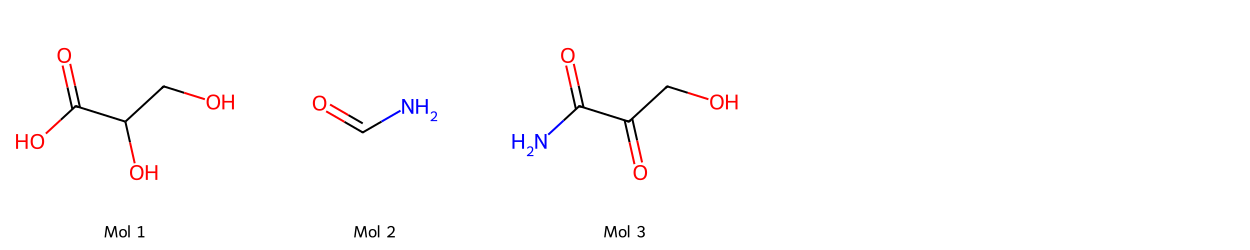

In [41]:
from IPython.display import display
display(visualize_molecules(mols[:]))
